# Run the file containing the functions used in this script
## By default this is a file called "methane_functions.r" in the working directory of this script
## Do NOT change the working directory at any point while using this script.

In [1]:
# is this the folder with the script in it?
scriptDir<-getwd()
scriptDir

# if not, uncomment and use this instead
# scriptDir<-""

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane"

In [24]:
methaneFunctions<-paste(scriptDir,"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane/methane_functions.r"

# 0. Load packages used

In [3]:
# Package names
packages <- c("dplyr", "doBy", "lubridate", "ggplot2", "Hmisc", "zoo", "viridis", "gam", "ggeffects", "reshape2", "mgcv")
packageHandler(packages)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: viridisLite

Loading required package: splines

Loading required package: foreach

Loaded gam 1.22-2


Loading required package: nlme


Attac

# 1. Locate data directory:

In [4]:
# 2023-05-30 Anya PWA dock run
directory<-"~/Desktop/data/Methane Calibration/Methane_Calibration_Anya/20230530" #Ken's location

# 2. Create output directory:

In [5]:
# create output directory path based on input directory
outputDir<-paste0(directory,"_output")

# create the output directory if necessary
newDir(dirPath = outputDir)

Output directory not found, creating: ~/Desktop/data/Methane Calibration/Methane_Calibration_Anya/20230530_output


# 3. Read in data from both RRIV and LGR
note: can separate paths for LGR and RRIV if you want, but concat_dirs should work anyways making use of the filePattern argument

In [22]:
# read_rriv_CSV eliminates debug lines and lines where the logger is NA
rriv_data<-concat_dirs(directory, read_rriv_CSV, filePattern=".CSV", minFileSize=400)

# process columns to be useful variable types, some columns may need to be done manually
rriv_data<-process_rriv_columns(rriv_data)

[1] "Dataframe generated, manually process column types if necessary"


In [43]:
# read_GA_ZIP is gas analyzer specific
# note, will not included viable .txt files that weren't zipped...
lgr_data<-concat_dirs(directory, read_GA_ZIP, ".zip", 300)

# delete unzipped files
clean_temp()

# process time column from character
lgr_data$Time<-lubridate::as_datetime(lgr_data$Time)

[1] "Dataframe generated, manually process column types if necessary"


In [32]:
# # the txt file we were including here was just from running on the lab bench while pulling data
# lgr_data2<-concat_dirs(directory, read_GA_TXT, ".txt$", 100)
# lgr_data<-rbind(lgr_data,lgr_data2)

[1] "Dataframe generated, manually process column types if necessary"


In [19]:
range(rriv_data$time.h)

[1] "2023-05-30 14:51:02 UTC" "2023-05-30 17:20:25 UTC"

In [29]:
# names(rriv_data)

In [30]:
# str(rriv_data)

In [124]:
# str(lgr_data$Time)

# str(lgr_data$Time)

In [44]:
range(lgr_data$Time)

[1] "2023-05-30 15:02:26 UTC" "2023-05-30 17:09:20 UTC"

# 4. Align time frames of both data sets

In [47]:
# range(rriv_data$time.h)[1]
# range(lgr_data$Time)[1]

# range(rriv_data$time.h)[2]
# range(lgr_data$Time)[2]

In [127]:
# start time is the max between the starting points for each range
start<-max(range(rriv_data$time.h)[1],range(lgr_data$Time)[1])

# end time is the min between the ending points for each range
end<-min(range(rriv_data$time.h)[2],range(lgr_data$Time)[2])

# subset the rriv data
rriv_data_overlap<-rriv_data[rriv_data$time.h>start & rriv_data$time.h<end,]
range(rriv_data_overlap$time.h)

# subset the lgr data
lgr_data_overlap<-lgr_data[lgr_data$Time>start & lgr_data$Time<end,]
range(lgr_data_overlap$Time)

[1] "2023-05-30 15:02:26 UTC" "2023-05-30 17:09:19 UTC"

[1] "2023-05-30 15:04:07 UTC" "2023-05-30 17:07:39 UTC"

In [157]:
rriv_data_ol_raw<-rriv_data_overlap[rriv_data_overlap$type=="raw",]
rriv_data_ol_summary<-rriv_data_overlap[rriv_data_overlap$type=="summary",]

In [159]:
names(lgr_data_overlap)

[1] "Time"               "X.CH4._ppm"         "X.CH4._ppm_sd"     
 [4] "X.CO2._ppm"         "X.CO2._ppm_sd"      "X.H2O._ppm"        
 [7] "X.H2O._ppm_sd"      "X.CH4.d_ppm"        "X.CH4.d_ppm_sd"    
[10] "X.CO2.d_ppm"        "X.CO2.d_ppm_sd"     "GasP_torr"         
[13] "GasP_torr_sd"       "GasT_C"             "GasT_C_sd"         
[16] "AmbT_C"             "AmbT_C_sd"          "RD0_us"            
[19] "RD0_us_sd"          "RD1_us"             "RD1_us_sd"         
[22] "RD0_raw_us"         "LTC0_v"             "LTC0_v_sd"         
[25] "LTC1_v"             "LTC1_v_sd"          "HZ"                
[28] "HZ_sd"              "Batt_v"             "Batt_v_sd"         
[31] "BattPer"            "BattPer_sd"         "Temp_Status_mA"    
[34] "Analyzer_Status_mA" "Fit_Flag"           "MIU_VALVE"         
[37] "MIU_DESC"

# 4.1 raw plots

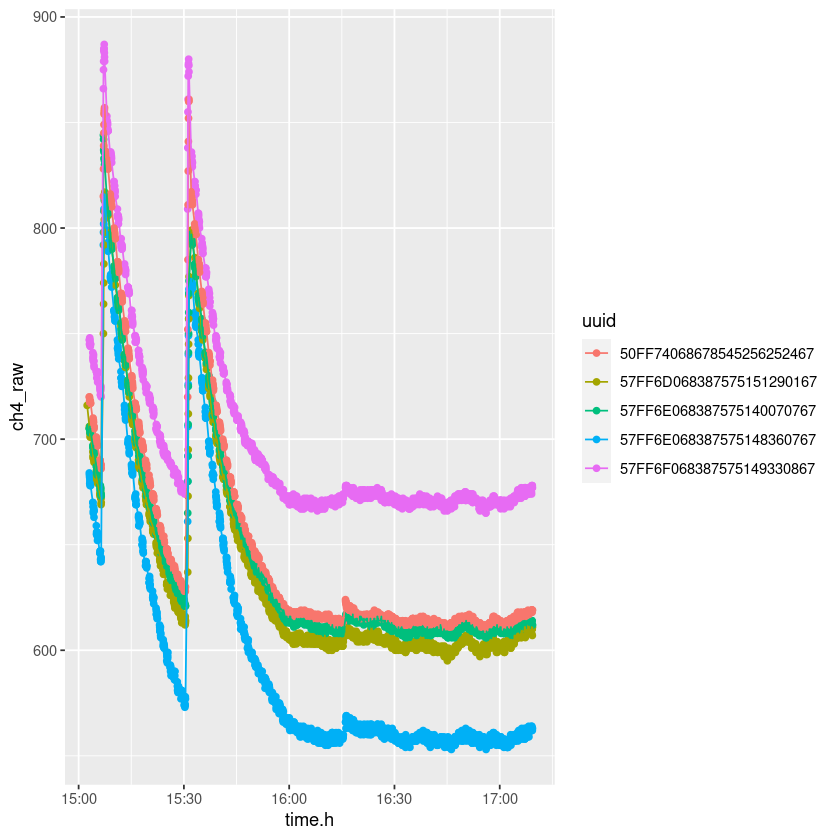

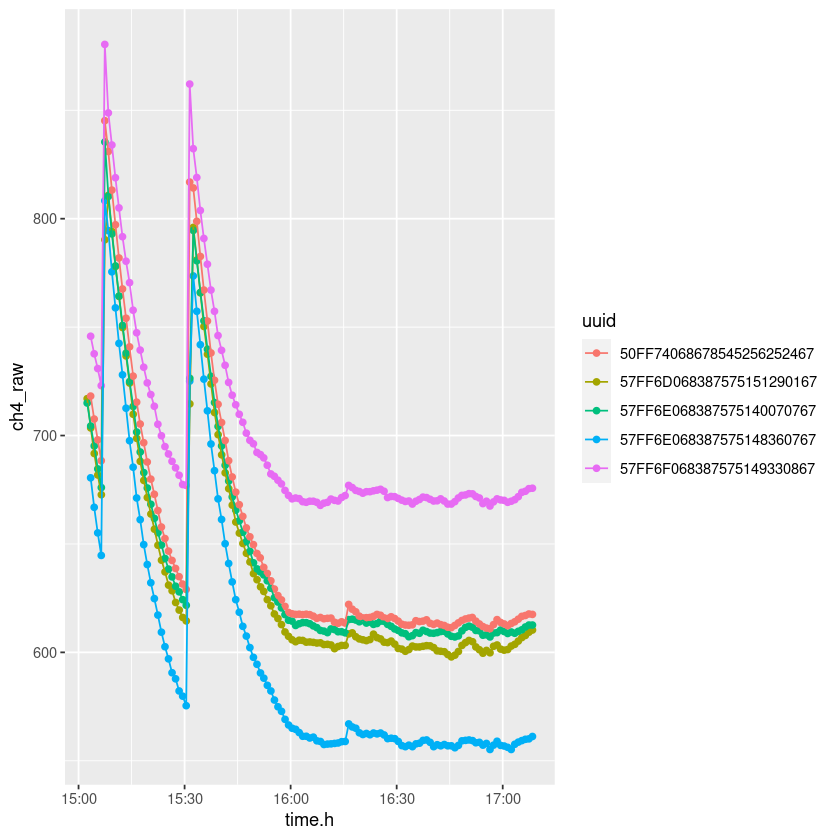

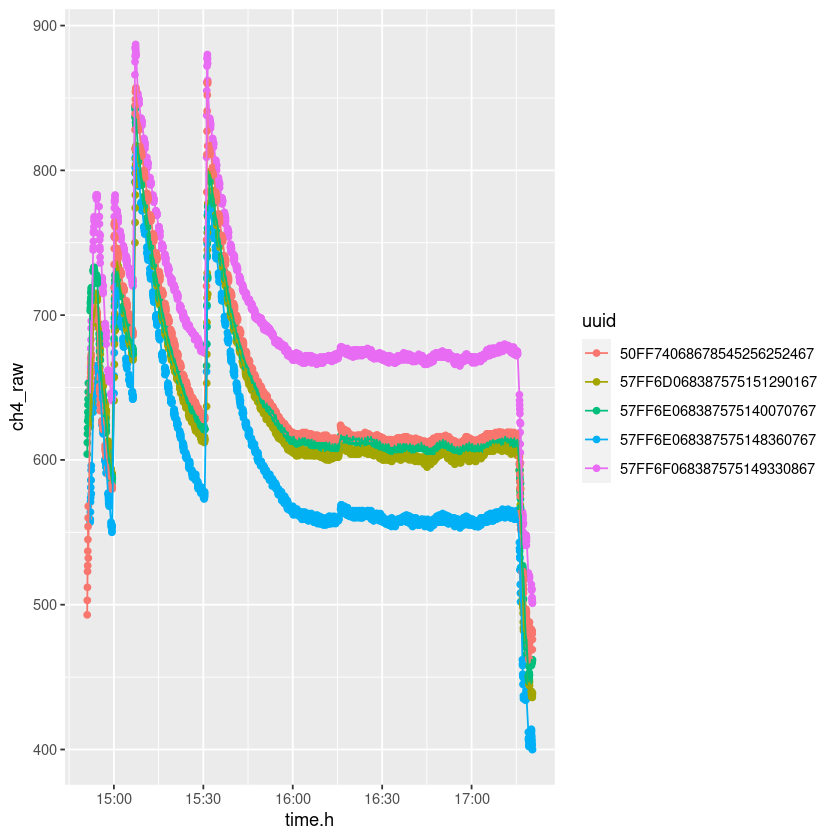

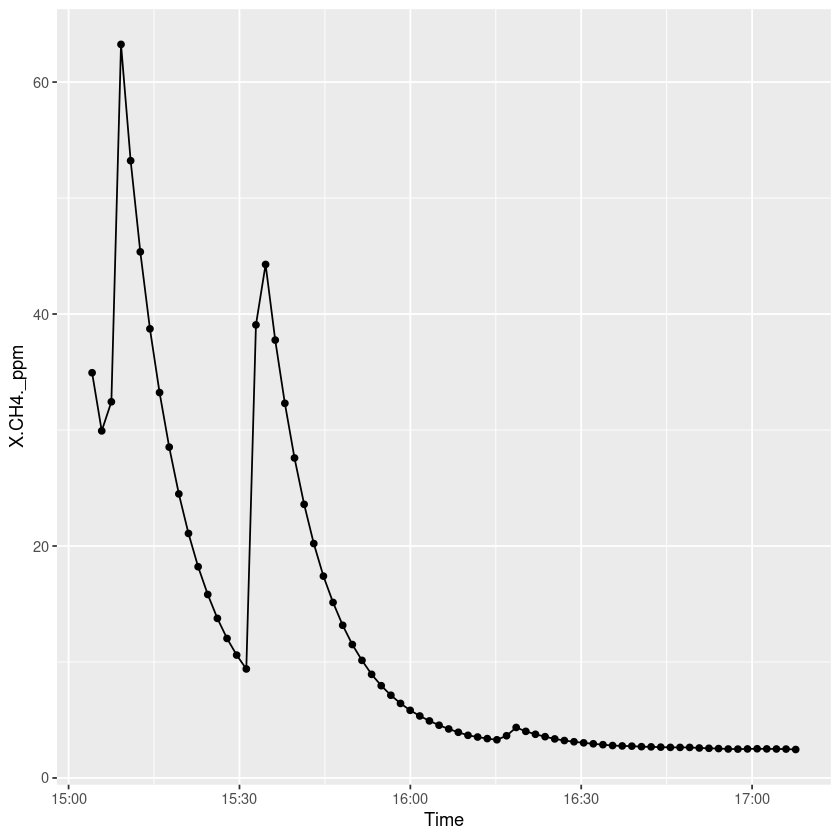

In [161]:
ggplot(rriv_data_ol_raw, aes(x=time.h, y=ch4_raw, color=uuid))+geom_point()+geom_line()

ggplot(rriv_data_ol_summary, aes(x=time.h, y=ch4_raw, color=uuid))+geom_point()+geom_line()

ggplot(rriv_data, aes(x=time.h, y=ch4_raw, color=uuid))+geom_point()+geom_line()

ggplot(lgr_data_overlap, aes(x=Time, y=X.CH4._ppm))+geom_point()+geom_line()

# 5. Interpolate data into a new dataframe

In [134]:
# # use sequence to create minute intervals across the range of rriv_data for data points in a new dataframe
# interpolated_data<-data.frame(time_utc=seq(range(rriv_data_overlap$time.h)[1], 
#                                            range(rriv_data_overlap$time.h)[2], by = "min"))

In [163]:
# # extract time range for first data frame
# df1r<-range(rriv_data_overlap$time.h)

# # extract time range for second data frame
# df2r<-range(lgr_data_overlap$Time)

# # df1r[2]-df1r[1]
# # df2r[2]-df2r[1]

# if(df1r[2]-df1r[1] > df2r[2]-df2r[1]){
#     print("df1 time range is larger")
#     outputDF<-data.frame(time_utc=seq(df1r[1],df1r[2], by="min"))
# } else{
#     print("df2 time range is larger")
#     outputDF<-data.frame(time_utc=seq(df2r[1],df2r[2], by="min"))
# }


[1] "df1 time range is larger"


In [126]:
# names(rriv_data)
# names(lgr_data)

In [127]:
# range(rriv_data_overlap$time.h)
# range(lgr_data_overlap$Time)

In [81]:
# interpolated_data<-data.frame(time.h=seq(range(rriv_data_overlap$time.h)[1], range(rriv_data_overlap$time.h)[2], by = "min"))

In [131]:
# Manually create dictionary for column names, and what to rename them to in output df
interpolateDict<-c(
        "ch4_raw"="ch4_raw_rriv",
        "aht_C"="aht_C",
        "aht_RH"="aht_RH",
        "dht_C"="dht_C",
        "dht_RH"="dht_RH",
        "X.CH4._ppm"="ch4_ppm_lgr")

In [108]:
interpolateData<-function(df1=rriv_data_overlap, df1TimeCol="time.h",
                          df2=lgr_data_overlap, df2TimeCol="Time",
                          iDict=interpolateDict){
    iD<-iDict
    iKeys<-names(iD)
    
    # extract time range for first data frame
    df1r<-range(df1[[ df1TimeCol ]])

    # extract time range for second data frame
    df2r<-range(df2[[ df2TimeCol ]])

    # create output dataframe using whichever time range is larger
    # use sequence to create minute intervals across the range for data points in a new dataframe
    if(df1r[2]-df1r[1] > df2r[2]-df2r[1]){
        print("df1 time range is larger")
        outputDF<-data.frame(time_utc=seq(df1r[1],df1r[2], by="min"))
    } else{
        print("df2 time range is larger")
        outputDF<-data.frame(time_utc=seq(df2r[1],df2r[2], by="min"))
    }
    
    # extract column names from dataframe 1
    cols<-names(df1)

    # only interpolate data that is both in the dictionary and in the column names
    for(key in iKeys[iKeys %in% cols]){
        outputDF[[ iD[[key]] ]]<-approx(df1[[df1TimeCol]], df1[[key]], outputDF[["time_utc"]])$y
    }

    # extract column names from dataframe 2
    cols<-names(df2)

    # only interpolate data that is both in the dictionary and in the column names
    for(key in iKeys[iKeys %in% cols]){
        outputDF[[ iD[[key]] ]]<-approx(df2[[df2TimeCol]], df2[[key]], outputDF[["time_utc"]])$y
    }

    # remove lines with NA
    outputDF<-outputDF[complete.cases(outputDF),]
    
    return(outputDF)
}

In [109]:
unique(rriv_data_overlap$uuid)

[1] 57FF6E068387575148360767 57FF6D068387575151290167 57FF6F068387575149330867
[4] 57FF6E068387575140070767 50FF74068678545256252467
5 Levels: 50FF74068678545256252467 ... 57FF6F068387575149330867

In [128]:
UUIDdict=c(
    "57FF6E068387575148360767"="CAL1",
    "57FF6D068387575151290167"="CAL2",
    "57FF6F068387575149330867"="CAL3",
    "57FF6E068387575140070767"="CAL4",
    "50FF74068678545256252467"="CAL5")
UUIDdict

rriv_data_overlap<-createSensorColFromIDs(rriv_data_overlap,idCol = "uuid",dict = UUIDdict)

57FF6E068387575148360767 57FF6D068387575151290167 57FF6F068387575149330867 
                  "CAL1"                   "CAL2"                   "CAL3" 
57FF6E068387575140070767 50FF74068678545256252467 
                  "CAL4"                   "CAL5"

In [129]:
head(rriv_data_overlap)

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,burstCycle,aht_C,aht_RH,ch4_raw,ch4_cal,user_note,user_value,Sensor
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>
832,raw,PDock1,CAL1,PWAdock-cal1.1-57FF6E068387575148360767-1685455590,1685455590,57FF6E068387575148360767,1685458983,2023-05-30 15:03:02,1187,35849,12,37.26,46.31,684,0,NA,NA,CAL1
839,raw,PDock1,CAL1,PWAdock-cal1.1-57FF6E068387575148360767-1685455590,1685455590,57FF6E068387575148360767,1685458985,2023-05-30 15:03:05,1169,35849,12,37.27,46.31,683,0,NA,NA,CAL1
846,raw,PDock1,CAL1,PWAdock-cal1.1-57FF6E068387575148360767-1685455590,1685455590,57FF6E068387575148360767,1685458988,2023-05-30 15:03:07,1166,35849,12,37.27,46.30,682,0,NA,NA,CAL1
853,raw,PDock1,CAL1,PWAdock-cal1.1-57FF6E068387575148360767-1685455590,1685455590,57FF6E068387575148360767,1685458990,2023-05-30 15:03:10,1164,35849,12,37.29,46.29,679,0,NA,NA,CAL1
860,raw,PDock1,CAL1,PWAdock-cal1.1-57FF6E068387575148360767-1685455590,1685455590,57FF6E068387575148360767,1685458993,2023-05-30 15:03:12,1160,35849,12,37.28,46.33,681,0,NA,NA,CAL1
867,raw,PDock1,CAL1,PWAdock-cal1.1-57FF6E068387575148360767-1685455590,1685455590,57FF6E068387575148360767,1685458995,2023-05-30 15:03:15,1162,35849,12,37.28,46.36,678,0,NA,NA,CAL1


In [142]:
# interpolate data for each uuid then merge via rbind()
interpolated_data<-data.frame()

sensorList<-unique(rriv_data_overlap$Sensor)

for(sensor in sensorList){
    subset<-rriv_data_overlap[rriv_data_overlap$Sensor==sensor,]
    temp<-interpolateData(df1=subset)
    temp$Sensor=sensor
    interpolated_data<-rbind(interpolated_data, temp)
}
unique(interpolated_data$Sensor)

[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"


[1] "CAL1" "CAL2" "CAL3" "CAL4" "CAL5"

In [143]:
head(interpolated_data)

,time_utc,ch4_raw_rriv,aht_C,aht_RH,ch4_ppm_lgr,Sensor
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3,2023-05-30 15:05:02,659.0261,37.53963,46.67960,32.21357,CAL1
4,2023-05-30 15:06:02,646.0449,37.62965,46.75980,30.26278,CAL1
5,2023-05-30 15:07:02,791.0282,37.68969,46.88938,31.74445,CAL1
6,2023-05-30 15:08:02,799.0763,37.76957,46.96944,42.17429,CAL1
7,2023-05-30 15:09:02,777.1722,37.87908,47.18809,60.38934,CAL1
8,2023-05-30 15:10:02,761.1674,37.96920,47.52649,58.25238,CAL1


In [144]:
# Calculate sensor resistance(Rs) using Figaro(manufacturer) equation
# Rs = (VC/VRL-1)*RL where
# VC = circuit voltage
# VRL = output voltage
# RL = load resistance
# 3-code 272 = 2.7kohm
RL = 2.7*1000  #convert kOhm to Ohm
VC = 5

# convert digital signal to voltage
interpolated_data$ch4_V=5/4096*interpolated_data$ch4_raw_rriv

# calculate sensor resistance (Rs)
interpolated_data$Rs_fig<-(VC/interpolated_data$ch4_V-1)*RL

# calculate absolute humidity from celsius and relative humidity
interpolated_data<-calcAbsoluteHumidity(interpolated_data,celsius = "aht_C",relativeHumidity = "aht_RH")

head(interpolated_data)

,time_utc,ch4_raw_rriv,aht_C,aht_RH,ch4_ppm_lgr,Sensor,ch4_V,Rs_fig,ews_mbar,ews_kPa,aH_gm3
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,2023-05-30 15:05:02,659.0261,37.53963,46.67960,32.21357,CAL1,0.8044752,14081.13,71.93708,7.193708,23.41909
4,2023-05-30 15:06:02,646.0449,37.62965,46.75980,30.26278,CAL1,0.7886290,14418.31,72.57724,7.257724,23.66123
5,2023-05-30 15:07:02,791.0282,37.68969,46.88938,31.74445,CAL1,0.9656106,11280.79,73.00713,7.300713,23.86273
6,2023-05-30 15:08:02,799.0763,37.76957,46.96944,42.17429,CAL1,0.9754350,11139.98,73.58276,7.358276,24.08575
7,2023-05-30 15:09:02,777.1722,37.87908,47.18809,60.38934,CAL1,0.9486966,11530.05,74.37872,7.437872,24.45102
8,2023-05-30 15:10:02,761.1674,37.96920,47.52649,58.25238,CAL1,0.9291594,11829.26,75.03971,7.503971,24.83802


# 5.1 preliminary plots

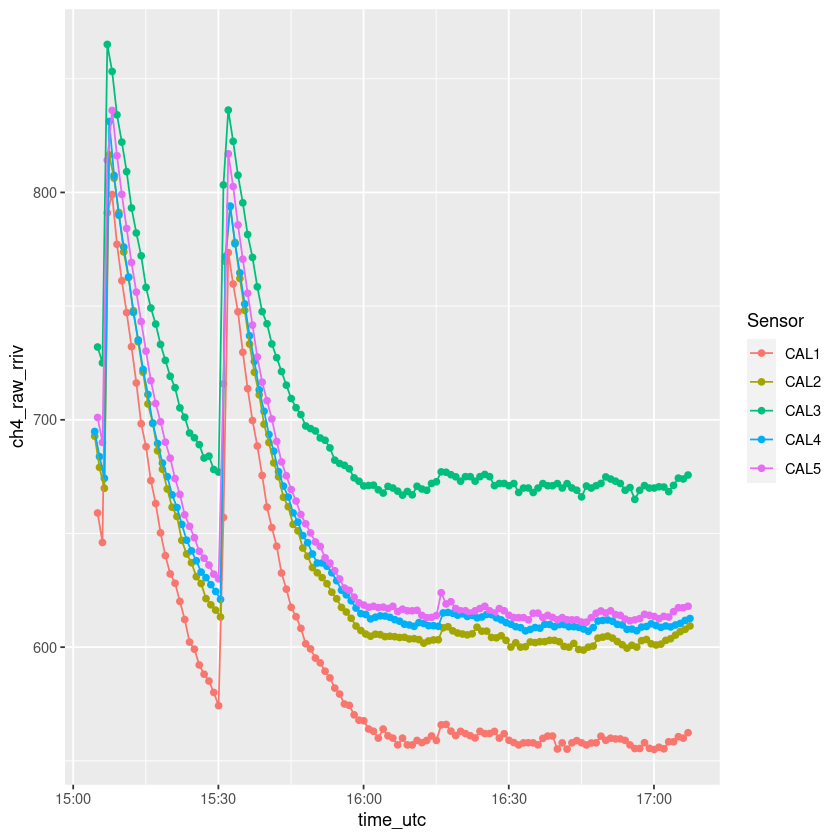

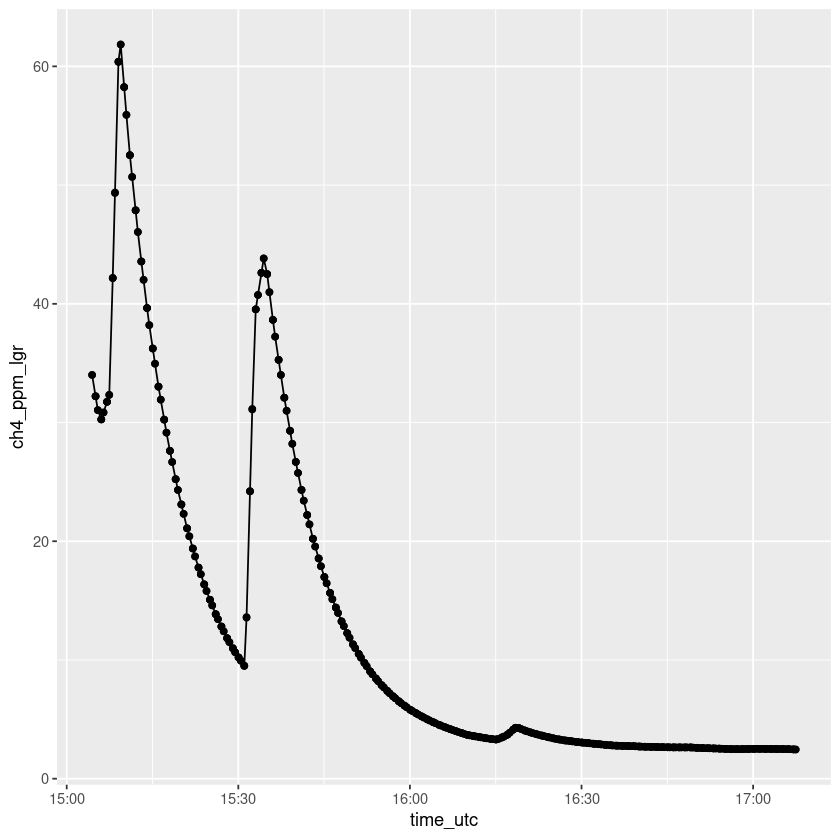

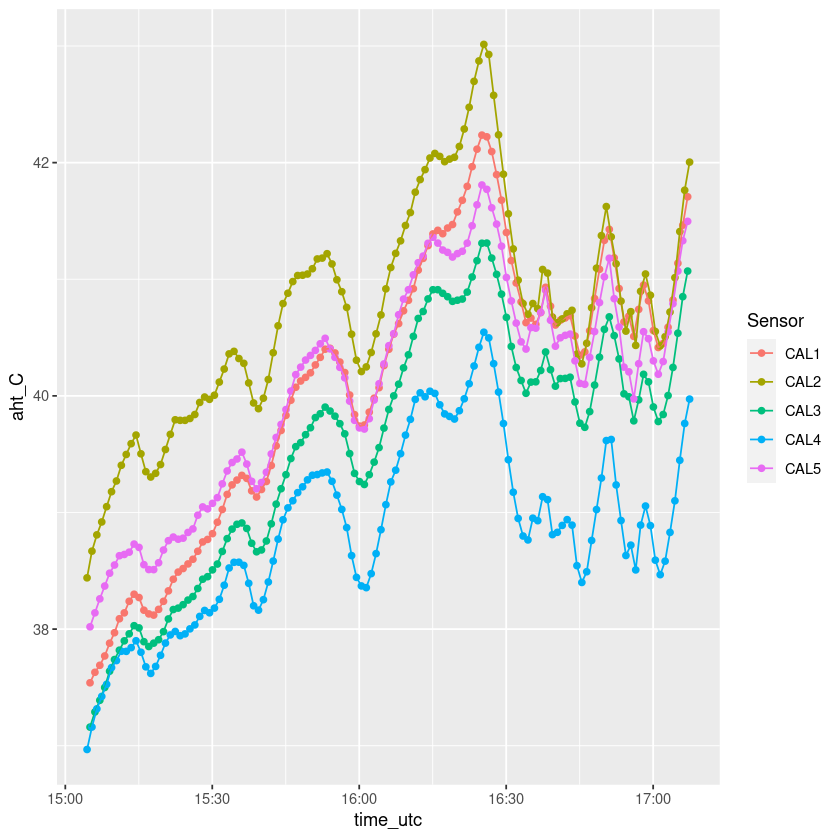

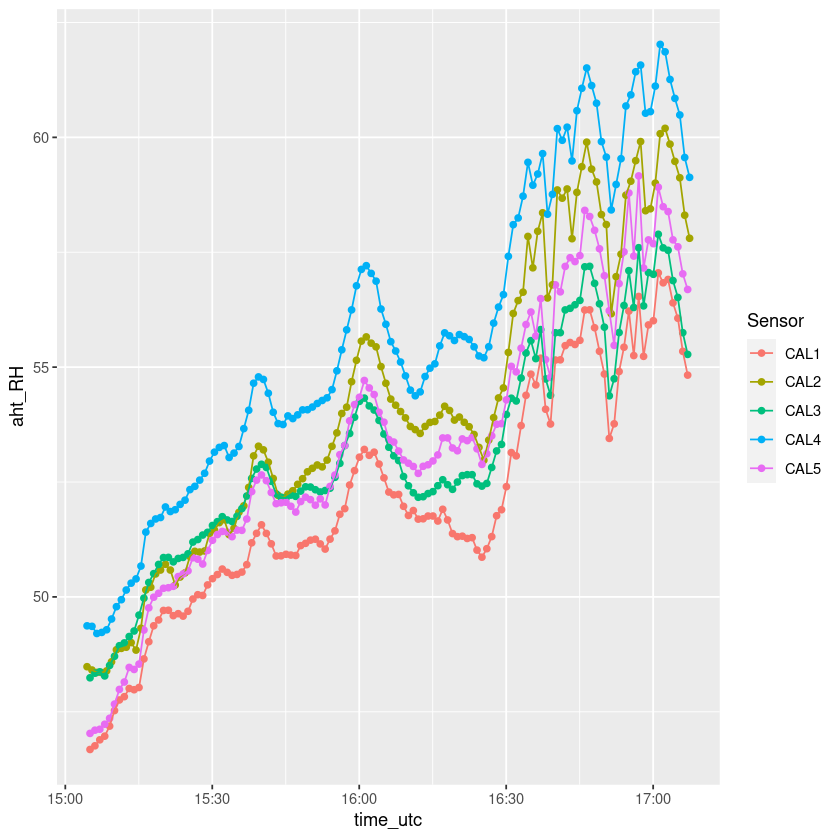

In [153]:
ggplot(interpolated_data, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+geom_line()

ggplot(interpolated_data, aes(x=time_utc, y=ch4_ppm_lgr))+geom_point()+geom_line()


ggplot(interpolated_data, aes(x=time_utc, y=aht_C, color=Sensor))+geom_point()+geom_line()

ggplot(interpolated_data, aes(x=time_utc, y=aht_RH, color=Sensor))+geom_point()+geom_line()

In [97]:
names(interpolated_data)

[1] "time_utc"     "ch4_raw_rriv" "aht_C"        "aht_RH"       "ch4_ppm_lgr" 
 [6] "ch4_V"        "Rs_fig"       "ews_mbar"     "ews_kPa"      "aH_gm3"

In [185]:
# df1<-rriv_data_overlap
# df1TimeCol<-"time.h"
# df2<-lgr_data_overlap
# df2TimeCol<-"Time"

# iD<-interpolateDict
# iK<-names(iD)

In [186]:
# # extract column names from dataframe 1
# cols<-names(df1)

# # only interpolate data that is both in the dictionary and in the column names
# for(key in iKeys[iKeys %in% cols]){
#     outputDF[[ iD[[key]] ]]<-approx(df1[[df1TimeCol]], df1[[key]], outputDF[["time_utc"]])$y
# }

# # extract column names from dataframe 2
# cols<-names(df2)

# # only interpolate data that is both in the dictionary and in the column names
# for(key in iKeys[iKeys %in% cols]){
#     outputDF[[ iD[[key]] ]]<-approx(df2[[df2TimeCol]], df2[[key]], outputDF[["time_utc"]])$y
# }

# # remove lines with NA
# outputDF<-outputDF[complete.cases(outputDF),]

In [187]:
# head(outputDF)

In [88]:
# interpolated_data$ch4_raw<-approx(rriv_data_overlap$time.h,rriv_data_overlap$ch4_raw, xout=interpolated_data$time.h)$y
# interpolated_data$aht_C<-approx(rriv_data_overlap$time.h,rriv_data_overlap$aht_C, xout=interpolated_data$time.h)$y
# interpolated_data$aht_RH<-approx(rriv_data_overlap$time.h,rriv_data_overlap$aht_RH, xout=interpolated_data$time.h)$y
# interpolated_data$CH4_ppm_lgr<-approx(lgr_data_overlap$Time,lgr_data_overlap$X.CH4._ppm, xout=interpolated_data$time.h)$y

In [188]:
# interpolated_data<-interpolated_data[complete.cases(interpolated_data),]
# head(interpolated_data)

# 6. Create Models from interpolated data
try Rs using figaro equation, relative humidity (aht_RH) -> absolute humidity

## GAM

### GAM 1: ch4_ppm_lgr ~ s(ch4_raw_rriv) + s(aht_C) + s(aht_RH)

In [54]:
gam_rriv<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated_data)
summary(gam_rriv)


Family: gaussian 
Link function: identity 

Formula:
ch4_ppm_lgr ~ s(ch4_raw_rriv) + s(aht_C) + s(aht_RH)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  12.6227     0.1409    89.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df     F p-value    
s(ch4_raw_rriv) 8.279  8.852 203.0  <2e-16 ***
s(aht_C)        8.906  8.996  13.7  <2e-16 ***
s(aht_RH)       8.510  8.932  51.5  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.988   Deviance explained =   99%
GCV =  3.136  Scale est. = 2.4608    n = 124

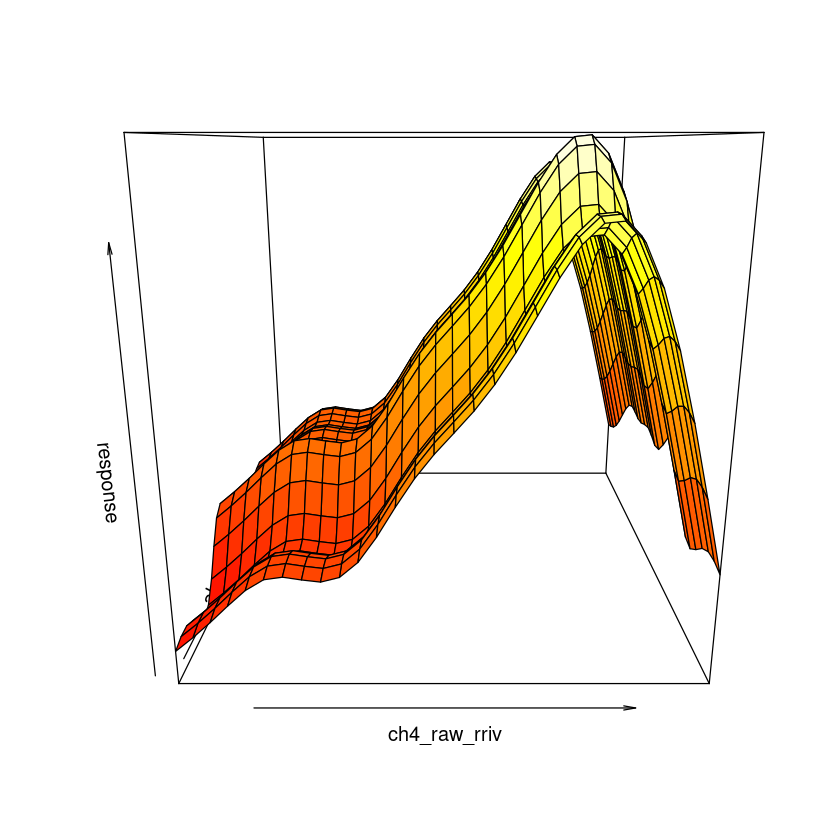

In [55]:
vis.gam(gam_rriv, type = "response", plot.type="persp")

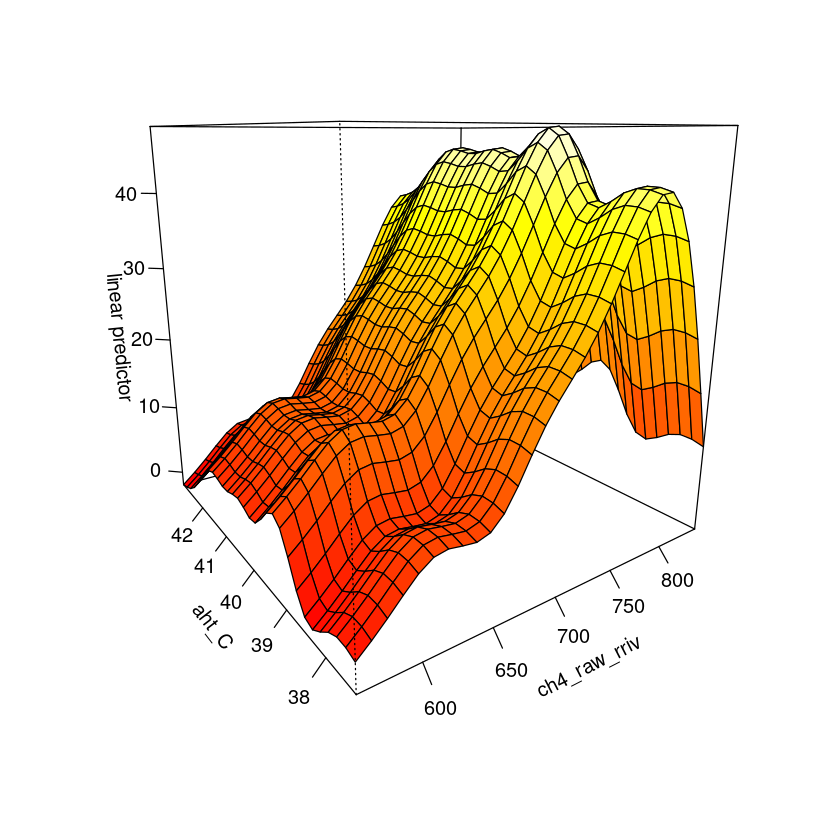

In [56]:
vis.gam(gam_rriv,ticktype="detailed",color="heat",theta=-35)

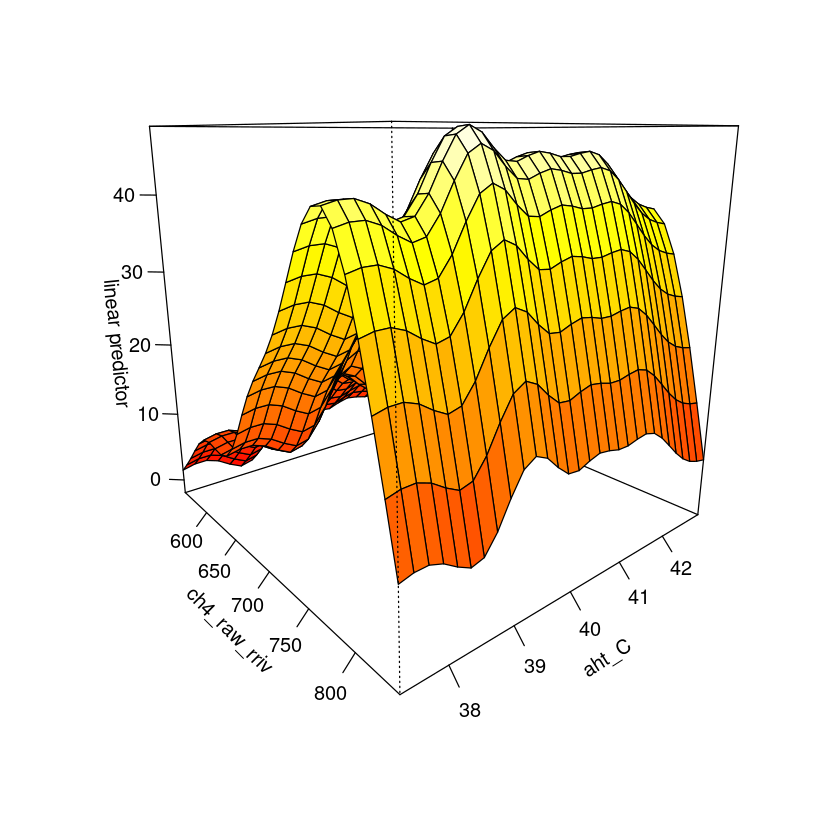

In [57]:
vis.gam(gam_rriv,ticktype="detailed",color="heat",theta=50)

In [58]:
predict(gam_rriv)->interpolated_data$predict_ch4

In [61]:
names(interpolated_data)

[1] "time_utc"     "ch4_raw_rriv" "aht_C"        "aht_RH"       "ch4_ppm_lgr" 
 [6] "ch4_V"        "Rs_fig"       "ews_mbar"     "ews_kPa"      "aH_gm3"      
[11] "predict_ch4"

In [67]:
# interpolated_data

In [68]:
head(interpolated_data)

melted_data<-melt(interpolated_data[,c("time_utc","ch4_ppm_lgr","predict_ch4")], id.vars="time_utc")

,time_utc,ch4_raw_rriv,aht_C,aht_RH,ch4_ppm_lgr,ch4_V,Rs_fig,ews_mbar,ews_kPa,aH_gm3,predict_ch4
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl[1d]>
3,2023-05-30 15:04:26,693.5020,37.71211,48.92677,34.01266,0.8465600,13246.89,73.16828,7.316828,24.95275,35.94961
4,2023-05-30 15:05:26,682.5327,37.35406,49.25785,31.05063,0.8331698,13503.18,70.63398,7.063398,24.27944,30.85927
5,2023-05-30 15:06:26,672.9756,37.34203,49.17333,30.84451,0.8215034,13733.28,70.55024,7.055024,24.20999,28.57514
6,2023-05-30 15:07:26,826.8201,37.47220,48.88032,32.32618,1.0093019,10675.58,71.46104,7.146104,24.36620,35.02206
7,2023-05-30 15:08:26,804.5042,37.58131,48.83196,49.32582,0.9820607,11046.60,72.23287,7.223287,24.59636,50.02045
8,2023-05-30 15:09:26,783.8187,37.76847,48.54208,61.85253,0.9568100,11409.38,73.57481,7.357481,24.88960,58.20974


Warning message:
“attributes are not identical across measure variables; they will be dropped”


In [70]:
melted_data

time_utc,variable,value
<dttm>,<fct>,<dbl>
2023-05-30 15:04:26,ch4_ppm_lgr,34.012655
2023-05-30 15:05:26,ch4_ppm_lgr,31.050627
2023-05-30 15:06:26,ch4_ppm_lgr,30.844509
2023-05-30 15:07:26,ch4_ppm_lgr,32.326181
2023-05-30 15:08:26,ch4_ppm_lgr,49.325824
2023-05-30 15:09:26,ch4_ppm_lgr,61.852529
2023-05-30 15:10:26,ch4_ppm_lgr,55.925227
2023-05-30 15:11:26,ch4_ppm_lgr,50.697141
2023-05-30 15:12:26,ch4_ppm_lgr,46.055913


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'time.h' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(c

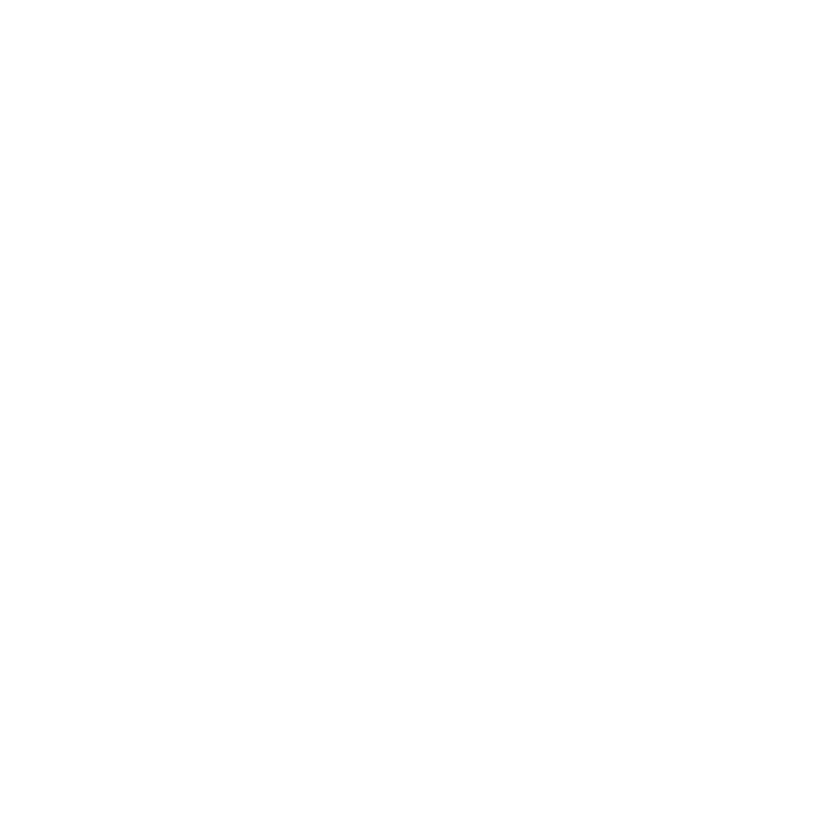

In [65]:
ggplot(data=melted_data,aes(x=time.h,y=value,color=variable))+geom_point()

### GAM 2: ch4_ppm_lgr ~ s(Rs_fig) + s(aht_C) + s(aH_gm3)

In [201]:
gam_rriv_2<-mgcv::gam(ch4_ppm_lgr~s(Rs_fig)+s(aht_C)+s(aH_gm3),data=interpolated_data)
summary(gam_rriv_2)


Family: gaussian 
Link function: identity 

Formula:
ch4_ppm_lgr ~ s(Rs_fig) + s(aht_C) + s(aH_gm3)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   56.493      0.935   60.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df        F p-value    
s(Rs_fig) 7.289  8.274 1134.063  <2e-16 ***
s(aht_C)  1.000  1.000    0.007   0.931    
s(aH_gm3) 1.000  1.000    0.018   0.893    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.988   Deviance explained = 98.8%
GCV = 248.87  Scale est. = 239.52    n = 274

### GAM 3: ch4_ppm_lgr ~ s(ch4_V) + s(aht_C) + s(aht_RH)

In [207]:
gam_rriv_3<-mgcv::gam(ch4_ppm_lgr~s(ch4_V)+s(aht_C)+s(aht_RH),data=interpolated_data)
summary(gam_rriv_3)


Family: gaussian 
Link function: identity 

Formula:
ch4_ppm_lgr ~ s(ch4_V) + s(aht_C) + s(aht_RH)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  56.4933     0.5066   111.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df       F p-value    
s(ch4_V)  8.947  8.998 425.332  <2e-16 ***
s(aht_C)  8.918  8.997  39.014  <2e-16 ***
s(aht_RH) 1.000  1.000   0.018   0.893    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.996   Deviance explained = 99.7%
GCV = 75.819  Scale est. = 70.322    n = 274

In [197]:
names(interpolated_data)

[1] "time_utc"     "ch4_raw_rriv" "aht_C"        "aht_RH"       "ch4_ppm_lgr" 
 [6] "ch4_V"        "Rs_fig"       "ews_mbar"     "ews_kPa"      "aH_gm3"

# 4. Initial Plots

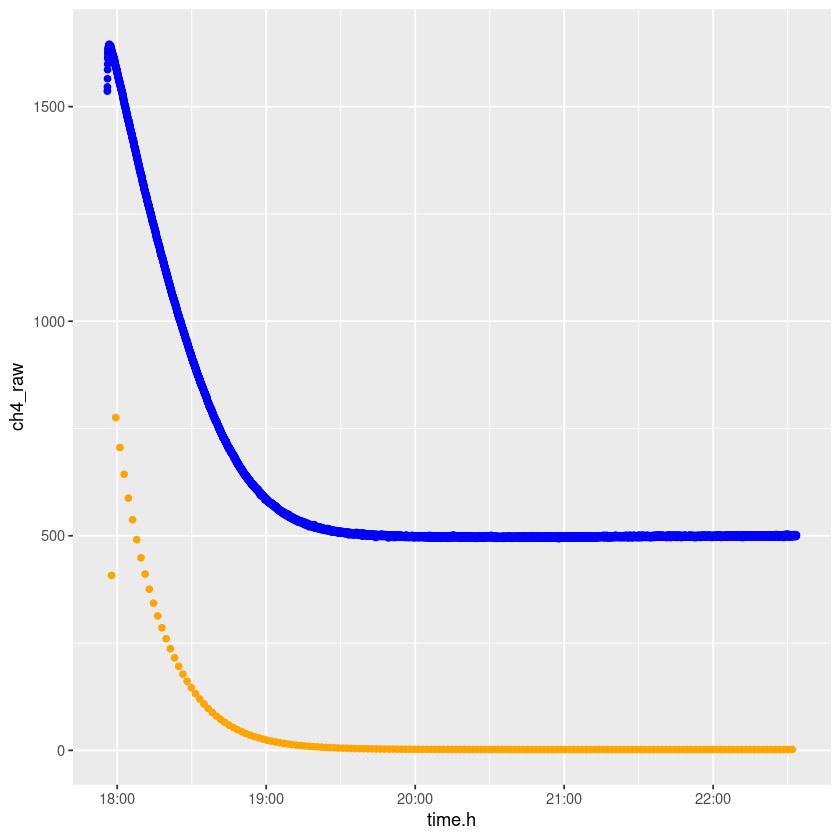

In [63]:
ggplot()+
    geom_point(data=rriv_data_overlap, aes(x=time.h,y=ch4_raw),color="blue")+
    geom_point(data=lgr_data_overlap, aes(x=Time,y=X.CH4._ppm),color="orange")

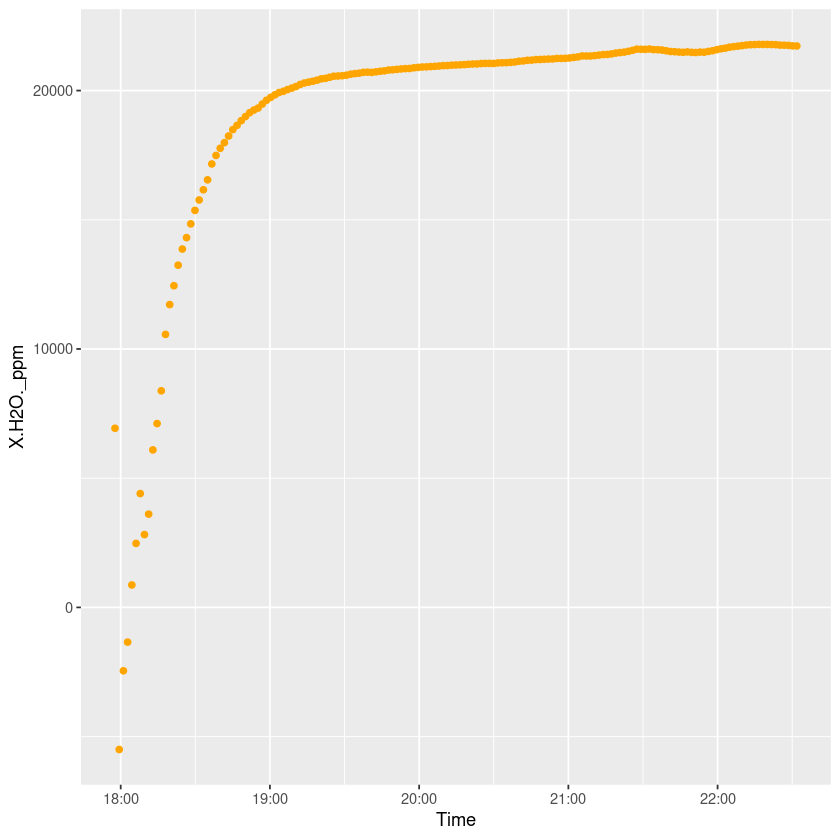

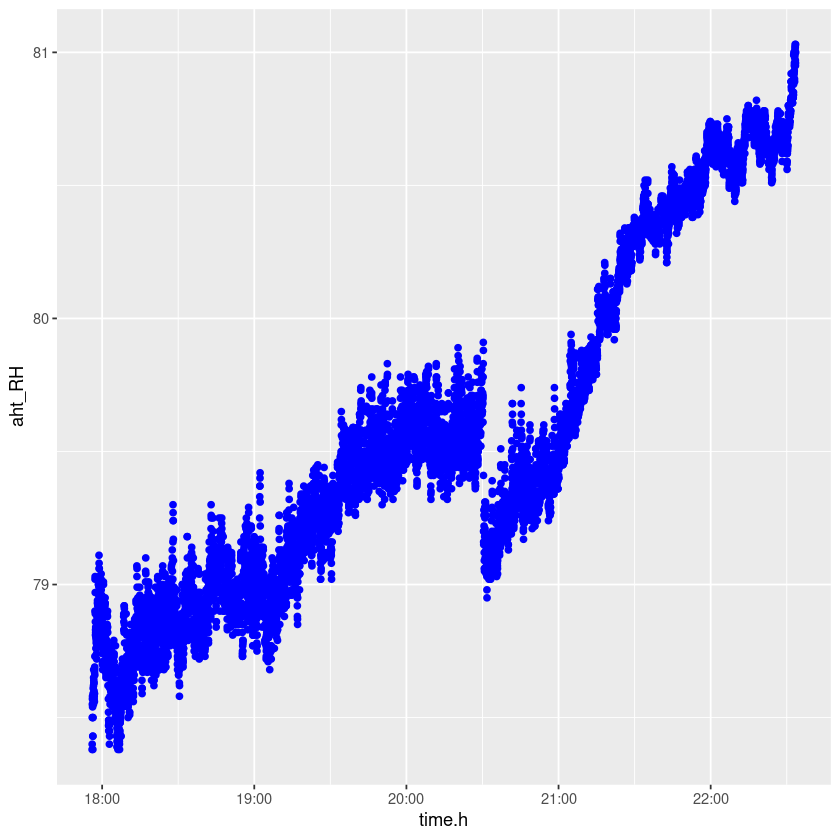

In [72]:
ggplot()+
    geom_point(data=lgr_data_overlap, aes(x=Time,y=X.H2O._ppm),color="orange")

ggplot()+
    geom_point(data=rriv_data_overlap, aes(x=time.h,y=aht_RH),color="blue")

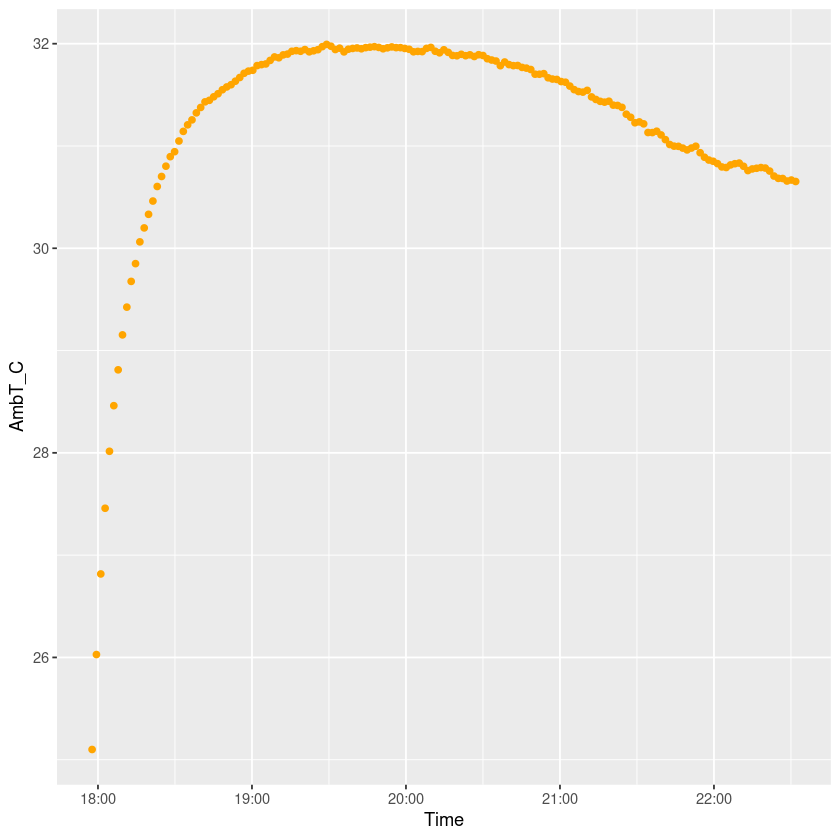

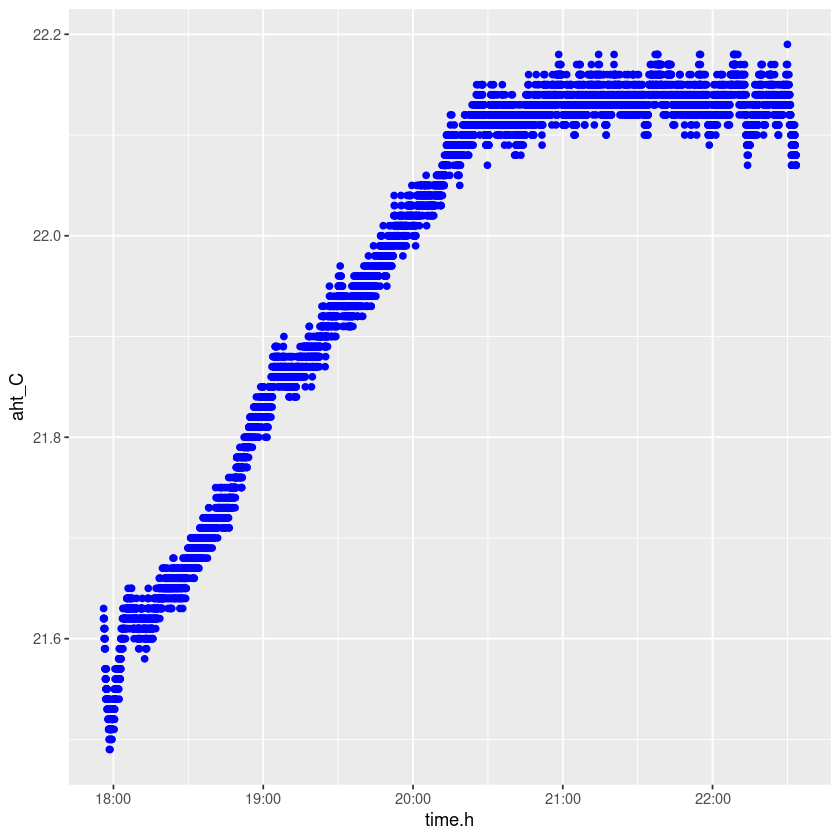

In [71]:
ggplot()+
    geom_point(data=lgr_data_overlap, aes(x=Time,y=AmbT_C),color="orange")

ggplot()+
    geom_point(data=rriv_data_overlap, aes(x=time.h,y=aht_C),color="blue")

notes:
4 resistors on NGM2611-E13 methane sensor module, can be scene on underside with 3 digit SMD code
https://kiloohm.info/smd3-resistor/272

R1 is 22kohm = 223
R2 is 6.8kOhm = 682
R3 is 6.8kOhm = 682
RL is 1.1kOhm to 4.7kohm

272 = 2.7kohm

Rs = (VC/VL-1)*RL